In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv("../../data/processed/tq_data_gridded/2024-09-03_gridded.csv")
df_train.head()

,ticker,sip_timestamp,ask_price,ask_size,bid_price,bid_size,last_trade_price,last_trade_size,mid_price
0,ADSK,2024-09-03 09:31:00,265.9,1.0,250.01,1.0,259.02,10.0,257.955
1,ADSK,2024-09-03 09:31:10,265.9,1.0,250.01,1.0,259.01,4.0,257.955
2,ADSK,2024-09-03 09:31:20,265.9,1.0,250.01,1.0,259.01,4.0,257.955
3,ADSK,2024-09-03 09:31:30,265.9,1.0,250.01,1.0,259.01,4.0,257.955
4,ADSK,2024-09-03 09:31:40,265.9,1.0,250.01,1.0,259.01,4.0,257.955


In [4]:
df_test = pd.read_csv("../../data/processed/tq_data_gridded/2024-09-17_gridded.csv")
df_test.head()

,ticker,sip_timestamp,ask_price,ask_size,bid_price,bid_size,last_trade_price,last_trade_size,mid_price
0,ADSK,2024-09-17 09:47:30,273.5,1.0,268.02,1.0,268.45,1.0,270.76
1,ADSK,2024-09-17 09:47:40,273.5,1.0,268.02,1.0,268.45,1.0,270.76
2,ADSK,2024-09-17 09:47:50,273.5,1.0,268.02,1.0,268.45,1.0,270.76
3,ADSK,2024-09-17 09:48:00,273.5,1.0,268.02,1.0,268.45,1.0,270.76
4,ADSK,2024-09-17 09:48:10,273.5,1.0,268.02,1.0,268.45,1.0,270.76


In [5]:
datapoints_per_ticker = df_train.groupby(by="ticker")["sip_timestamp"].apply("count").sort_values(ascending=False)
datapoints_per_ticker.head()

ticker
CB     2340
WBA    2340
UNP    2340
MMM    2339
TXN    2339
Name: sip_timestamp, dtype: int64

In [35]:
def create_sequences(data, seq_length=10):
    """
    Convert DataFrame into sequences of specified length for LSTM input.
    """
    x, y = [], []
    for i in range(len(data) - seq_length):
        # Create sequences of length `seq_length`
        x.append(data[i:i+seq_length, :-1])  # all columns except the last for features
        y.append(data[i+seq_length, -1])     # last column as target
    return np.array(x), np.array(y)

ticker = datapoints_per_ticker.index[0]

ticker_data_train = df_train[df_train["ticker"] == ticker]
ticker_data_train = ticker_data_train.drop(columns=["ticker", "sip_timestamp"])

scaler = MinMaxScaler()
data = scaler.fit_transform(ticker_data_train)

seq_length = 10  
X_train, y_train = create_sequences(data, seq_length)

model = Sequential([
    LSTM(32, activation='relu', input_shape=(seq_length, 6), return_sequences=True),
    LSTM(32, activation='relu', input_shape=(seq_length, 6), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=10, batch_size=32)

model.summary()

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1741
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0041
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026  
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026  
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 10, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,037 (156.40 KB)

 Trainable params: 13,345 (52.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,692 (104.27 KB)

In [36]:
ticker_data_test = df_test[df_test["ticker"] == ticker]
ticker_data_test = ticker_data_test.drop(columns=["ticker", "sip_timestamp"])
data = scaler.fit_transform(ticker_data_test)

X_test, y_test = create_sequences(data, seq_length)
y_pred = model.predict(X_test)

mse = np.mean((y_test-y_pred)**2)

print(f"Test MSE {mse}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MSE 0.017789190683814567


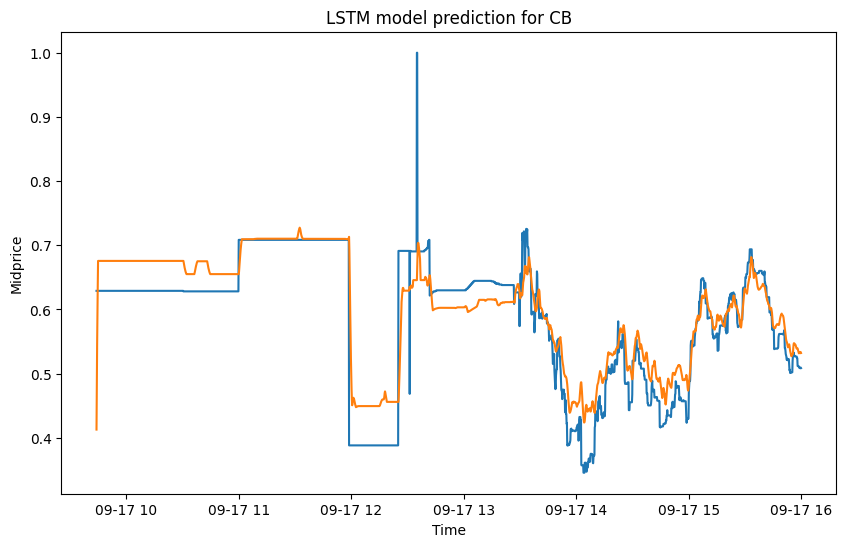

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df_test.loc[df_test["ticker"] == ticker, "sip_timestamp"].iloc[10:]), y_test, label="True")
plt.plot(pd.to_datetime(df_test.loc[df_test["ticker"] == ticker, "sip_timestamp"].iloc[10:]), y_pred, label="Pred")
plt.title(f"LSTM model prediction for {ticker}")
plt.ylabel("Midprice")
plt.xlabel("Time")
plt.show()

In [38]:
print(type(pd.to_datetime(df_test.loc[df_test["ticker"] == ticker, "sip_timestamp"].iloc[10:])))

<class 'pandas.core.series.Series'>
